In [2]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING
from vnpy.trader.app.ctaStrategy.ctaTemplate import CtaTemplate, BarManager
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import datetime, time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine

In [10]:
#合约代码
code = '600380'
exchange = 'SSE'
vtCode = '.'.join([code, exchange])
startDate = '20170101'
endDate = datetime.now().strftime('%Y%m%d')
#endDate = '20170601'

In [29]:
'''
课程策略
'''
class DualThrustStrategy(CtaTemplate):
    """DualThrust交易策略"""
    className = 'DualThrustStrategy'
    author = u'用Python的交易员'

    # 策略参数
    fixedSize = 100
    k1 = 0.4
    k2 = 0.6

    initDays = 10

    # 策略变量
    barList = []                # K线对象的列表

    dayOpen = 0
    dayHigh = 0
    dayLow = 0
    
    range = 0
    longEntry = 0
    shortEntry = 0
    exitTime = time(hour=14, minute=55)

    longEntered = False
    shortEntered = False

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'k1',
                 'k2']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'range',
               'longEntry',
               'shortEntry',
               'exitTime']  

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(DualThrustStrategy, self).__init__(ctaEngine, setting) 
        
        self.bm = BarManager(self.onBar)
        self.barList = []

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
    
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        '''
        print u'======收到TICK%s======' % tick.datetime
        print tick.lastPrice
        print '\n'
        '''
        theEndDate = datetime.strptime(endDate, '%Y%m%d')
        if tick.datetime.date() >= theEndDate.date():
            return
        self.bm.updateTick(tick)
        
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        # 撤销之前发出的尚未成交的委托（包括限价单和停止单）
        self.cancelAll()
        
        # 计算指标数值
        self.barList.append(bar)
        
        if len(self.barList) < 2:
            self.dayOpen = bar.open
            self.dayHigh = bar.high
            self.dayLow = bar.low
            return
        
        if len(self.barList) > 2:
            self.barList.pop(0)
            
        lastBar = self.barList[-2]
        # 新的一天
        if lastBar.datetime.date() != bar.datetime.date():
            '''
            print u'================新的一天 %s================' % bar.datetime
            '''
            # 如果已经初始化
            if self.dayHigh:
                self.range = self.dayHigh - self.dayLow
                self.longEntry = bar.open + self.k1 * self.range
                self.shortEntry = bar.open - self.k2 * self.range
                #'''
                print 'range %.2f' % self.range
                print '\n'
                #'''
            
            self.dayOpen = bar.open
            self.dayHigh = bar.high
            self.dayLow = bar.low
            '''
            print 'dayOpen = %.2f' % self.dayOpen
            print '\n'
            print 'longEntry = %.2f' % self.longEntry
            print 'shortEntry = %.2f' % self.shortEntry
            print '\n'
            '''

            self.longEntered = False
            self.shortEntered = False
        else:
            self.dayHigh = max(self.dayHigh, bar.high)
            self.dayLow = min(self.dayLow, bar.low)

        #第一天或者前一天没有波动
        if not self.range:
            return
        
        #尚未到收盘
        if bar.datetime.time() < self.exitTime:
            if self.pos == 0:
                if bar.close > self.dayOpen:
                    if not self.longEntered:
                        '''
                        print '======%s======' % bar.datetime
                        print u'开仓 多 %.2f' % self.longEntry
                        print '\n'
                        '''
                        self.buy(self.longEntry, self.fixedSize, stop=True)
                else:
                    if not self.shortEntered:
                        '''
                        print '======%s======' % bar.datetime
                        print '开仓 空 %.2f' % self.shortEntry
                        print '\n'
                        '''
                        self.short(self.shortEntry, self.fixedSize, stop=True)
    
            # 持有多头仓位
            elif self.pos > 0:
                self.longEntered = True
                '''
                print '======%s======' % bar.datetime
                print u'多头止损'
                print '\n'
                '''
                # 多头止损单
                self.sell(self.shortEntry, self.fixedSize, stop=True)
                
                # 空头开仓单
                if not self.shortEntered:
                    self.short(self.shortEntry, self.fixedSize, stop=True)
                
            # 持有空头仓位
            elif self.pos < 0:
                self.shortEntered = True
                '''
                print '======%s======' % bar.datetime
                print u'空头止损'
                print '\n'
                '''
                # 空头止损单
                self.cover(self.longEntry, self.fixedSize, stop=True)
                
                # 多头开仓单
                if not self.longEntered:
                    self.buy(self.longEntry, self.fixedSize, stop=True)
            
        # 收盘平仓
        else:
            #print'======%s======' %  bar.datetime
            if self.pos > 0:
                '''
                print u'多头平仓'
                print u'卖出价格：%.2f' % (bar.close*0.99)
                print '\n'
                '''
                self.sell(bar.close * 0.99, abs(self.pos))
            elif self.pos < 0:
                '''
                print u'空头平仓'
                print u'买入价格：%.2f' % (bar.close*1.01)
                print '\n'
                '''
                self.cover(bar.close * 1.01, abs(self.pos))
 
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        '''
        print u'==交易成功 %s=='  % trade.dt
        print u'方向:%s' % trade.direction
        print u'操作:%s' % trade.offset
        print u'价格:%s' % trade.price
        print u'当前持仓:%ld' % self.pos
        print '\n'
        '''
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [24]:
'''
我的策略
'''
class DualThrustStrategy(CtaTemplate):
    """DualThrust交易策略"""
    className = 'DualThrustStrategy'
    author = u'用Python的交易员'

    # 策略参数
    fixedSize = 100
    k1 = 0.4
    k2 = 0.6

    initDays = 10

    # 策略变量
    barList = []                # K线对象的列表

    dayOpen = 0
    dayClose = 0
    dayHigh = 0
    dayLow = 0
    
    range = 0
    longEntry = 0
    shortEntry = 0
    exitTime = time(hour=14, minute=55)

    longEntered = False
    shortEntered = False

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'k1',
                 'k2']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'range',
               'longEntry',
               'shortEntry',
               'exitTime']  

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(DualThrustStrategy, self).__init__(ctaEngine, setting) 
        
        self.bm = BarManager(self.onBar)
        self.barList = []

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
    
        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        '''
        print u'======收到TICK%s======' % tick.datetime
        print tick.lastPrice
        print '\n'
        '''
        theEndDate = datetime.strptime(endDate, '%Y%m%d')
        if tick.datetime.date() >= theEndDate.date():
            return
        self.bm.updateTick(tick)
        
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        # 撤销之前发出的尚未成交的委托（包括限价单和停止单）
        self.cancelAll()
        
        # 计算指标数值
        self.barList.append(bar)
        
        if len(self.barList) < 2:
            self.dayOpen = bar.open
            self.dayClose = bar.close
            self.dayHigh = bar.high
            self.dayLow = bar.low
            return
        
        if len(self.barList) > 2:
            self.barList.pop(0)
            
        lastBar = self.barList[-2]
        # 新的一天
        if lastBar.datetime.date() != bar.datetime.date():
            #'''
            print u'================新的一天 %s================' % bar.datetime
            #'''
            # 如果已经初始化
            if self.dayHigh:
                self.range = max((self.dayHigh - self.dayClose), (self.dayClose-self.dayLow))
                self.longEntry = bar.open + self.k1 * self.range
                self.shortEntry = bar.open - self.k2 * self.range
                '''
                print 'dayHight %.2f' % self.dayHigh
                print 'dayClose %.2f' % self.dayClose
                print 'dayLow %.2f' % self.dayLow
                print '\n'
                print 'dayHight-dayClose %.2f' % (self.dayHigh - self.dayClose)
                print 'dayClose-dayLow %.2f' % (self.dayClose-self.dayLow)
                print 'range %.2f' % self.range
                print '\n'
                '''
            
            self.dayOpen = bar.open
            self.dayClose = bar.close
            self.dayHigh = bar.high
            self.dayLow = bar.low
            '''
            print 'dayOpen = %.2f' % self.dayOpen
            print '\n'
            print 'longEntry = %.2f' % self.longEntry
            print 'shortEntry = %.2f' % self.shortEntry
            print '\n'
            '''

            self.longEntered = False
            self.shortEntered = False
        else:
            self.dayClose = bar.close
            self.dayHigh = max(self.dayHigh, bar.high)
            self.dayLow = min(self.dayLow, bar.low)

        #第一天或者前一天没有波动
        if not self.range:
            return
        
        #尚未到收盘
        if bar.datetime.time() < self.exitTime:
            if self.pos == 0:
                if bar.close > self.dayOpen:
                    if not self.longEntered:
                        '''
                        print '======%s======' % bar.datetime
                        print u'开仓 多 %.2f' % self.longEntry
                        print '\n'
                        '''
                        self.buy(self.longEntry, self.fixedSize, stop=True)
                else:
                    if not self.shortEntered:
                        '''
                        print '======%s======' % bar.datetime
                        print '开仓 空 %.2f' % self.shortEntry
                        print '\n'
                        '''
                        self.short(self.shortEntry, self.fixedSize, stop=True)
    
            # 持有多头仓位
            elif self.pos > 0:
                self.longEntered = True
                '''
                print '======%s======' % bar.datetime
                print u'多头止损'
                print '\n'
                '''
                # 多头止损单
                self.sell(self.shortEntry, self.fixedSize, stop=True)
                
                # 空头开仓单
                if not self.shortEntered:
                    self.short(self.shortEntry, self.fixedSize, stop=True)
                
            # 持有空头仓位
            elif self.pos < 0:
                self.shortEntered = True
                '''
                print '======%s======' % bar.datetime
                print u'空头止损'
                print '\n'
                '''
                # 空头止损单
                self.cover(self.longEntry, self.fixedSize, stop=True)
                
                # 多头开仓单
                if not self.longEntered:
                    self.buy(self.longEntry, self.fixedSize, stop=True)
            
        # 收盘平仓
        else:
            #print'======%s======' %  bar.datetime
            if self.pos > 0:
                '''
                print u'多头平仓'
                print u'卖出价格：%.2f' % (bar.close*0.99)
                print '\n'
                '''
                self.sell(bar.close * 0.99, abs(self.pos))
            elif self.pos < 0:
                '''
                print u'空头平仓'
                print u'买入价格：%.2f' % (bar.close*1.01)
                print '\n'
                '''
                self.cover(bar.close * 1.01, abs(self.pos))
 
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        '''
        print u'==交易成功 %s=='  % trade.dt
        print u'方向:%s' % trade.direction
        print u'操作:%s' % trade.offset
        print u'价格:%s' % trade.price
        print u'当前持仓:%ld' % self.pos
        print '\n'
        '''
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2017-11-14 18:01:45.334000	开始载入数据
2017-11-14 18:01:46.380000	载入完成，数据量：469356
2017-11-14 18:01:46.380000	开始回测
2017-11-14 18:01:46.408000	策略初始化完成
2017-11-14 18:01:46.408000	策略启动完成
2017-11-14 18:01:46.408000	开始回放数据
range 0.09


range 0.13


range 0.06


range 0.10


range 0.10


range 0.07


range 0.17


range 0.22


range 0.29


range 0.67


range 0.20


range 0.10


range 0.15


range 0.15


range 0.14


range 0.05


range 0.13


range 0.18


range 0.12


range 0.16


range 0.15


range 0.15


range 0.18


range 0.11


range 0.21


range 0.11


range 0.13


range 0.10


range 0.18


range 0.13


range 0.23


range 0.16


range 0.17


range 0.11


range 0.55


range 0.17


range 0.50


range 0.19


range 0.15


range 0.11


range 0.18


range 0.17


range 0.17


range 0.08


range 0.22


range 0.14


range 0.09


range 0.08


range 0.15


range 0.14


range 0.07


range 0.13


range 0.20


range 0.11


range 0.09


range 0.29


range 0.16


range 0.18


range 0.16


range 0.15


range 0.

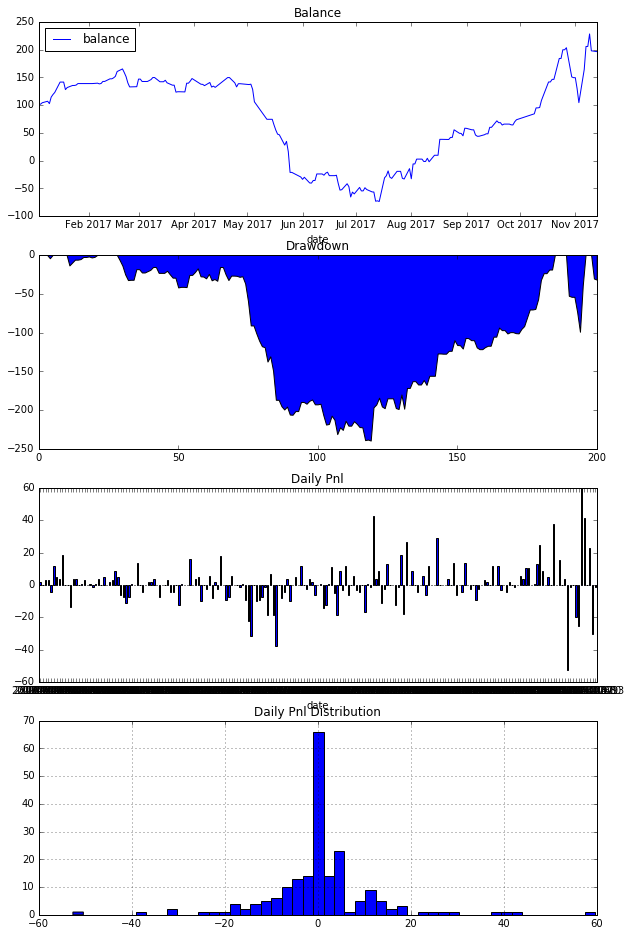

In [30]:
'''
回测
'''
#初始化数据需要的自然日天数
initDays = 3
#初始资金
DualThrustStrategy.capital = 100

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate(startDate, initDays = initDays) #这里的initDays是真正起作用的

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.5/10000)       #股票交易手续费万1.5
engine.setSize(1)               #股票每股为1
engine.setPriceTick(0.01)      #股票最小价格变动
engine.setCapital(DualThrustStrategy.capital) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(DualThrustStrategy, {})

#开始跑回测
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()